In [1]:
import networkx as nx
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import logging
import numpy as np
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.wkt import loads
from scipy.spatial.distance import cdist
import pandas as pd
import plotly.graph_objects as go

# Let's brag about digital twins ;)

import sgp_dt as dt


In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kelu/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_c

In [2]:
# to play with the lib in real time
%load_ext autoreload
%autoreload 2

# Checking what we have in the network

In [3]:
data_obj = dt.loadPrecomputedData()

2021-06-07 21:36:08.472 INFO    root: Section loadPrecomputedData completed in: 0.368192195892334 seconds


In [4]:
G, df_nodes,gTrees, gLamps, gPark, gCCTV = dt.loadShp("data/s4/SingaporeLampsCCTVTrees.shp")

2021-06-07 21:36:08.509 INFO    root: reading network
2021-06-07 21:36:16.031 INFO    root: reading df_nodes
2021-06-07 21:36:16.074 INFO    root: reading gTrees
2021-06-07 21:36:27.614 INFO    root: reading sLamps
2021-06-07 21:36:30.207 INFO    root: reading sParks
2021-06-07 21:36:30.499 INFO    root: reading sCCTV
2021-06-07 21:36:30.566 INFO    root: Section loadShp completed in: 22.05609393119812 seconds


In [5]:
gTrees["x"] = gTrees.geometry.x
gTrees["y"] = gTrees.geometry.y

gLamps["x"] = gLamps.geometry.x
gLamps["y"] = gLamps.geometry.y

In [6]:
UseDummyPoints = True

prefs = {}
prefs['cctv'] = 1 
prefs['lamps'] = 1 
prefs['tunnels'] = 1  
prefs['pedestrian'] = 1  

prefs['stairs'] = 1  
 
prefs['trees'] = 1 


plotCCTV = False
plotLamps =  False
plotTrees = False
plotPark = False


In [7]:
start_point = "Masjid Sultan, Singapore"
end_point = "Rochor Link Bridge, Singapore"
start,end = dt.getStartEnd(start_point, end_point, data_obj['df_nodes'])
print(start,end )

2021-06-07 21:36:30.822 INFO    root: start_point: <class 'str'>
2021-06-07 21:36:31.630 INFO    root: Section closest_point completed in: 0.044202566146850586 seconds
2021-06-07 21:36:31.681 INFO    root: Section closest_point completed in: 0.04447770118713379 seconds
2021-06-07 21:36:31.687 INFO    root: Section getStartEnd completed in: 0.8652582168579102 seconds


(103.8587353, 1.3024228) (103.8662118, 1.3056971)


In [8]:
weighted_G  = dt.modernGraphWeightUpdates(data_obj['G'], prefs)

2021-06-07 21:36:32.041 INFO    root: Section modernGraphWeightUpdates completed in: 0.3025858402252197 seconds


In [20]:
fig, route, border = dt.mapIt(start,end,weighted_G)

2021-06-07 21:43:04.581 INFO    root: Section plot_path completed in: 0.013972997665405273 seconds
2021-06-07 21:43:04.582 INFO    root: Section mapIt completed in: 0.08574175834655762 seconds


In [21]:
fig

In [22]:
df = pd.DataFrame(route, columns =['y', 'x'])
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.y, df.x))
zone = gdf.buffer(0.001).unary_union

In [23]:
xmin, ymin, xmax, ymax = zone.bounds
xmin, ymin, xmax, ymax

(103.8567636, 1.3009485, 103.8706253, 1.3109601999999998)

In [24]:
arbres = gTrees.loc[gTrees.within(zone)]
fig = dt.add_gdf_to_figure(fig, arbres, "Trees", "Green", opacity=0.45, size=10) 

2021-06-07 21:43:06.634 INFO    root: Section add_gdf_to_figure completed in: 0.0009756088256835938 seconds


In [25]:
Lamps = gLamps.loc[gLamps.within(zone)]

fig = dt.add_gdf_to_figure(fig, Lamps, "Lights", "Red", opacity=0.9, size=5) 

2021-06-07 21:43:06.932 INFO    root: Section add_gdf_to_figure completed in: 0.0009968280792236328 seconds


In [26]:
fig

# What do we have?

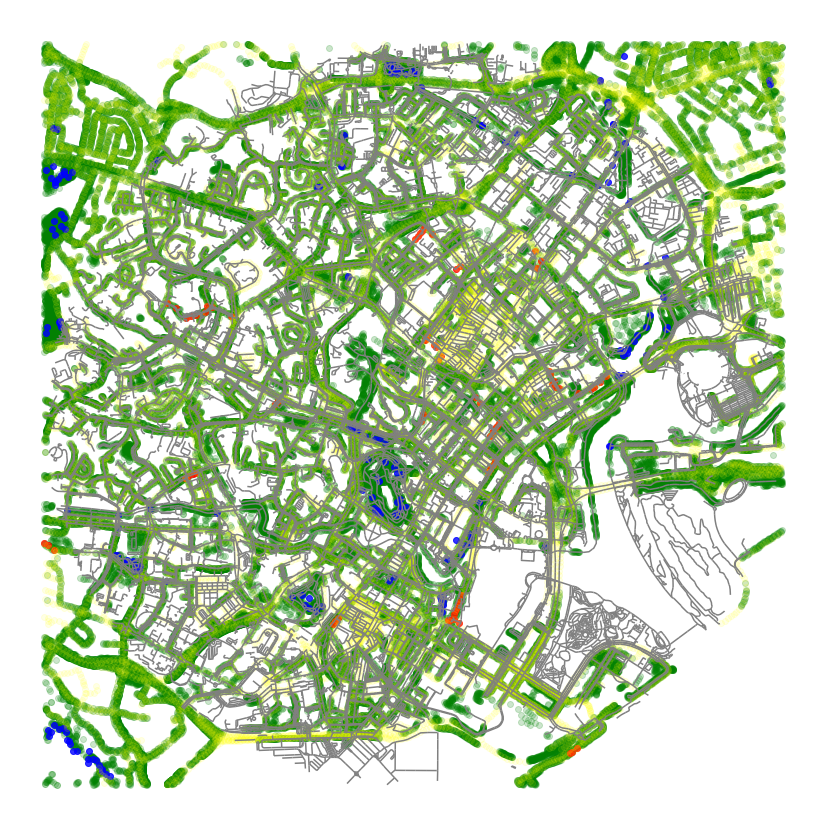

In [47]:
xmin, ymin, xmax, ymax = SLC.total_bounds

fig,ax = plt.subplots(figsize=(15,15))
#ax = ox.project_gdf(SLC).plot(figsize=(20,20)) 
SLC.plot(ax=ax, color="grey")
gTrees.cx[xmin:xmax, ymin:ymax].plot(ax=ax, alpha=0.2, color="green")
gPark.cx[xmin:xmax, ymin:ymax].plot(ax=ax, alpha=0.8, color="blue")
gCCTV.cx[xmin:xmax, ymin:ymax].plot(ax=ax, alpha=0.8, color="red")
gLamps.cx[xmin:xmax, ymin:ymax].plot(ax=ax, alpha=0.1, color="yellow")
_ = ax.axis('off')